In [3]:
from IPython.display import display, HTML , Markdown
from snowflake.snowpark.session import Session
from PIL import Image
import pandas as pd
import logging
import tqdm
import glob
import numpy as np

# Import the commonly defined utility scripts using
# dynamic path include
import sys
sys.path.append('../src/python/lutils')
import sflk_base as L

display(Markdown("### Initialization"))
logging.basicConfig(stream=sys.stdout, level=logging.ERROR)

# Source various helper functions
%run ./scripts/notebook_helpers.py

# Define the project home directory, this is used for locating the config.ini file
PROJECT_HOME_DIR = '../'
config = L.get_config(PROJECT_HOME_DIR)
session = L.connect_to_snowflake(PROJECT_HOME_DIR)

if(session == None):
   raise Exception(f'Unable to connect to snowflake. Validate connection information ')

session.use_role(f'''{config['APP_DB']['role']}''')
session.use_schema(f'''{config['APP_DB']['database']}.{config['APP_DB']['schema']}''')
session.use_warehouse(f'''{config['SNOW_CONN']['warehouse']}''')

df1 = session.sql('select current_user() ,current_role() ,current_database() ,current_schema();').to_pandas()
display(df1)

### Initialization

,CURRENT_USER(),CURRENT_ROLE(),CURRENT_DATABASE(),CURRENT_SCHEMA()
0,JPRUSA,SYSADMIN,FASHION,PUBLIC


## Image Resizing

In [4]:
# preprocess data
# convert all images to 3 channels (remove alpha if present)
# resize to be smaller (256 on the smaller dimension)
# save with class added to file name 
image_paths = glob.glob('../data_raw/**/*.jpg', recursive=True)
for path in tqdm.tqdm(image_paths):
    img = Image.open(path)
    if np.asarray(img).shape[-1] != 3:
        img = img.convert('RGB')
    w,h = img.size
    scale_factor = min(w/256, h/256)
    new_size = (int(w/scale_factor), int(h/scale_factor))
    img = img.resize(new_size)
    new_name = '_'.join(path.split('/')[-2:])
    img.save(f'../data_preprocessed/{new_name}')

100%|███████████████████████████████████████| 5762/5762 [12:08<00:00,  7.91it/s]


## Encoding Images into a Table
we use base64 encoding to encode our images into a column of byte strings

In [5]:
%%time
# encode/decode

import base64
from io import BytesIO

def decode(data):
    return Image.open(BytesIO(base64.b64decode(data)))

# encode data into table

images = glob.glob("../data_preprocessed/*.jpg")
labels = []
names = []
data = []
for img in tqdm.tqdm(images):
    names.append(img.split('/')[-1])
    labels.append(img.split('/')[-1].split('_')[0])
    with open(img, "rb") as image_file:
        data.append(base64.b64encode(image_file.read()).decode("utf-8"))

df_base64 = pd.DataFrame(
    {
        'LABEL': labels,
        'NAME': names,
        'DATA': data
    }
)

100%|█████████████████████████████████████| 5762/5762 [00:01<00:00, 5561.44it/s]

CPU times: user 203 ms, sys: 243 ms, total: 447 ms
Wall time: 1.06 s


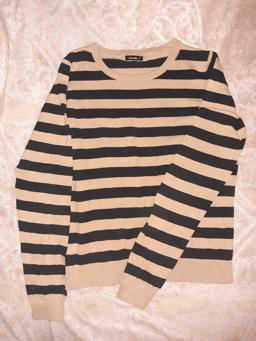

In [6]:
# check that we can decode data back into images
data = df_base64.DATA[2]
decode(data)

In [7]:
%%time
# upload dataframe into snowflake table
sdf = session.create_dataframe(df_base64)
sdf.write.save_as_table(table_name="IMAGES_ENCODED", mode='overwrite')

CPU times: user 4.58 s, sys: 837 ms, total: 5.41 s
Wall time: 1min 20s


In [8]:
# resizing: 12:12 minutes
# encoding: 1.21 seconds
# creating snowflake df: 1:15 minutes
# writing to DB: 2.11 seconds

# Total preprocessing time beginning to end ~14 minutes. 
# However, once it writes to the database, I will make sure that the preprocessing is skipped in the future. Basically I'll write a function to check whether there exists a table. If so, then skip preprocessing. SO this is a 1 time done deal

In [22]:
session.table("IMAGES_ENCODED").limit(1).to_pandas()


,LABEL,NAME,DATA
0,t,t_shirt_8b82657d-eb42-4468-a073-2513eb0d40f1.jpg,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
